In [1]:
import os
import sys
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, roc_auc_score, auc, precision_recall_curve
from sklearn.metrics import average_precision_score

np.random.seed(2019)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import lightgbm as lgb

In [2]:
base_path = os.path.abspath('../..')
data_path = os.path.join(base_path, 'data')
database_path = os.path.join(data_path, 'database')
strategy_path = os.path.join(base_path, 'strategy')
sys.path.append(strategy_path)

In [3]:
from strategy import CommodityStrategy, EquityStrategy, IRStrategy, EmergingStrategy
from tester import Tester

In [4]:
from models.CRNN import CRNN_model

# 1. Data

In [5]:
strategy = EquityStrategy(strategy_name="EPM", asset_type="EQUITY")

2019-10-17 18:46:52,129 - EPM - INFO - [STEP 0] START LOGGING EPM


In [6]:
strategy.load_index_and_return(from_db=True, save_file=False)

2019-10-17 18:46:52,137 - EPM - INFO - [STEP 1] LOAD DATA
2019-10-17 18:46:52,138 - EPM - INFO - [STEP 1 - 1] CONNECT TO BLOOM DATABASE
2019-10-17 18:46:52,147 - EPM - INFO - [STEP 1 - 2] GET DATA FROM BLOOM AND PAST DATABASE
2019-10-17 18:49:40,608 - EPM - INFO - [STEP 1 - 3] CHANGE BLOOM AND PAST DATA INTO STANDARD FORMAT
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(**kwargs)
2019-10-17 18:49:40,990 - EPM - INFO - [STEP 1 - 4] MERGE BLOOM AND PAST DATA


In [7]:
df_index = strategy.index
df_index_return = strategy.ret

In [8]:
df_index = df_index.loc[:'2019-07']
df_index_return = df_index_return.loc[:'2019-07']

# 2. Explore

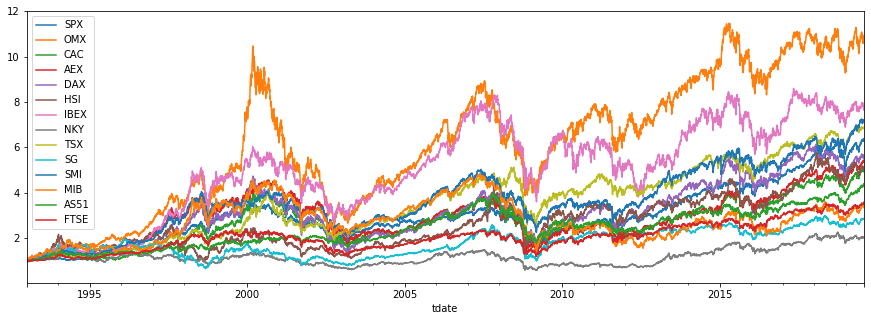

In [9]:
plt.figure(figsize=(15,5))
for column in df_index.columns:
    df_index[column].plot()
plt.legend()

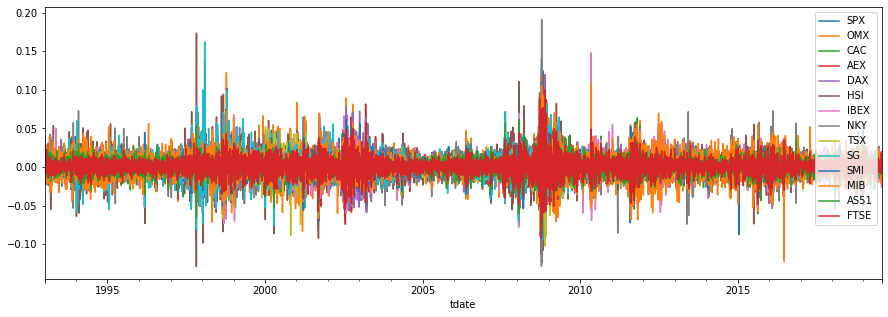

In [10]:
plt.figure(figsize=(15,5))
for column in df_index_return.columns:
    df_index_return[column].plot()
plt.legend()

# 3. Model

### 1. Time Series

In [11]:
CRNN_params = {
    'use_cnn': False,
    'num_filters': [64, 32],
    'filter_size': [3, 3],
    'cnn_batch_norm': [True, True],
    'pool_sizes': [1, 2],
    'cnn_dropout_keep_prob': [0, 0.2],
    'use_fc': False,
    'fc_hidden_units': [1028, 512, 256],
    'fc_batch_norm': [True, True, True],
    'fc_dropout_keep_prob': [0.1, 0.3, 0.3],
    'use_rnn': True,
    'rnn_n_hiddens': [256, 128],
    'rnn_dropout_keep_prob': [0.7, 0.8],
    'use_layer_normalization': True,
    'bi_rnn': False,
    'use_gap': False
}

### 2. Cross Sectional

In [12]:
indiv_momentum_lst = [5, 10, 21, 42, 63, 126, 189, 252]

## 1. X

### average return

In [13]:
avg_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_ret['avg_ret_' + str(period)] = df_index_return.rolling(period).mean()

### average vol

In [14]:
avg_vol  = {}
for i, period in enumerate(indiv_momentum_lst):
    avg_vol['avg_vol_' + str(period)] = df_index_return.rolling(period).std()

### cum return

In [15]:
cum_ret  = {}
for i, period in enumerate(indiv_momentum_lst):
    cum_ret['cum_ret_' + str(period)] = df_index.pct_change(period)

In [16]:
df_mom_avg_ret = pd.concat(avg_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_avg_vol = pd.concat(avg_vol, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]
df_mom_cum_ret = pd.concat(cum_ret, axis=1).stack().reset_index().set_index('tdate').loc['1994-01-01':]

# CASE 1-1: BINARY

## 2. Y

In [17]:
one_week = 5
one_month = 20

In [18]:
df_index_rank = df_index.pct_change(one_week).shift(-1 * one_week).rank(axis=1) 

In [19]:
df_index_y_binary = df_index_rank > 7.5
df_index_y_binary = df_index_y_binary.astype(np.float32)

In [20]:
df_y = df_index_y_binary.unstack().reset_index()
df_y = df_y.set_index('tdate').loc['1994':]
df_y.columns = ['ticker', 'y']

In [21]:
df_mom_cum_ret.reset_index(inplace=True)
df_mom_avg_ret.reset_index(inplace=True)
df_mom_avg_vol.reset_index(inplace=True)

df_join = pd.merge(df_y, df_mom_avg_ret, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_avg_vol, on=['tdate', 'ticker'])
df_join = pd.merge(df_join, df_mom_cum_ret, on=['tdate', 'ticker'])

df_train = df_join.loc[df_join['tdate'] <= pd.to_datetime('2010-12-31')]
df_val = df_join.loc[(df_join['tdate'] >= pd.to_datetime('2009-01-01')) & (df_join['tdate'] <= pd.to_datetime('2010-12-31'))]
df_test = df_join.loc[df_join['tdate'] >= pd.to_datetime('2011-01-01')]

df_train_y = df_train['y']
df_train_x = df_train[df_train.columns[3:]]

df_val_y = df_val['y']
df_val_x = df_val[df_val.columns[3:]]

df_test_y = df_test['y']
df_test_x = df_test[df_test.columns[3:]]

In [22]:
def train(train_x, train_y1, val_x, val_y1, num_boost_round=1000, learning_rate=0.01, early_stopping_rounds=50, verbose=None):
    params1 = {"objective": "binary",
          "boosting_type": "gbdt",
          "num_boost_round": num_boost_round,
          'max_depth': 3,
          'num_leaves': 25,
          "learning_rate": learning_rate,
          "feature_fraction": 0.8,
          "subsample": 0.8,
          "verbosity": 1,
          "metric": 'binary_logloss'
          }              
    
    train_data = lgb.Dataset(train_x, train_y1)
    val_data = lgb.Dataset(val_x, val_y1)
    lgb_model = lgb.train(train_set=train_data, params=params1, early_stopping_rounds=early_stopping_rounds,
                          valid_sets=[train_data, val_data], verbose_eval=verbose)
    
    train_pred = lgb_model.predict(train_x)
    val_pred = lgb_model.predict(val_x)
    return lgb_model, train_pred, val_pred

In [23]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692833	valid_1's binary_logloss: 0.692838
[20]	training's binary_logloss: 0.692546	valid_1's binary_logloss: 0.692591
[30]	training's binary_logloss: 0.692291	valid_1's binary_logloss: 0.692397
[40]	training's binary_logloss: 0.692065	valid_1's binary_logloss: 0.692212
[50]	training's binary_logloss: 0.69186	valid_1's binary_logloss: 0.692072
[60]	training's binary_logloss: 0.691675	valid_1's binary_logloss: 0.69193
[70]	training's binary_logloss: 0.691493	valid_1's binary_logloss: 0.691741
[80]	training's binary_logloss: 0.691319	valid_1's binary_logloss: 0.691597
[90]	training's binary_logloss: 0.691144	valid_1's binary_logloss: 0.691467
[100]	training's binary_logloss: 0.690972	valid_1's binary_logloss: 0.691336
[110]	training's binary_logloss: 0.690816	valid_1's binary_logloss: 0.691214
[120]	training's binary_logloss: 0.690665	valid_1's binary_logloss: 0.691077
[130]	training's binary_l

In [24]:
lgb_models = []
lgb_train_pred1 = []
lgb_val_pred1 = []

model, train_pred, val_pred = train(df_train_x.values, df_train_y.values, df_val_x.values, df_val_y.values, 
                                    num_boost_round=500, 
                                    learning_rate=0.01, 
                                    verbose=10,
                                    early_stopping_rounds=500)
test_pred = model.predict(df_test_x.values)

Training until validation scores don't improve for 500 rounds
[10]	training's binary_logloss: 0.692833	valid_1's binary_logloss: 0.692838
[20]	training's binary_logloss: 0.692546	valid_1's binary_logloss: 0.692591
[30]	training's binary_logloss: 0.692291	valid_1's binary_logloss: 0.692397
[40]	training's binary_logloss: 0.692065	valid_1's binary_logloss: 0.692212
[50]	training's binary_logloss: 0.69186	valid_1's binary_logloss: 0.692072
[60]	training's binary_logloss: 0.691675	valid_1's binary_logloss: 0.69193
[70]	training's binary_logloss: 0.691493	valid_1's binary_logloss: 0.691741
[80]	training's binary_logloss: 0.691319	valid_1's binary_logloss: 0.691597
[90]	training's binary_logloss: 0.691144	valid_1's binary_logloss: 0.691467
[100]	training's binary_logloss: 0.690972	valid_1's binary_logloss: 0.691336
[110]	training's binary_logloss: 0.690816	valid_1's binary_logloss: 0.691214
[120]	training's binary_logloss: 0.690665	valid_1's binary_logloss: 0.691077
[130]	training's binary_l

In [25]:
df_train['y_pred'] = train_pred
df_val['y_pred'] = val_pred
df_test['y_pred'] = test_pred

df_train_pred = pd.pivot_table(df_train, columns='ticker', index='tdate', values='y_pred')
df_val_pred = pd.pivot_table(df_val, columns='ticker', index='tdate', values='y_pred')
df_test_pred = pd.pivot_table(df_test, columns='ticker', index='tdate', values='y_pred')

df_pred = pd.concat([df_train_pred, df_val_pred, df_test_pred], axis=0)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

# 3. LONG SHORT SIGNAL